In [2]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, mannwhitneyu, linregress
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import *
import pyBigWig
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader
sources = ["FLAIRseq", "RNAseq"]

## 1. select genes

In [17]:
path = "../../1_FLAIRseq/reports/gene_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv"
d = pd.read_csv(path, sep="\t", index_col=0)
d = d[d["GeneType"] == "protein_coding"]
d["A0"] = d["TPM"]
d["K"] = d["A0"] * np.log(2) / d["T"]
d = d[(d["A0"] >= 20) & (np.isfinite(d["K"]))]
d.to_csv("results/selected_genes.FLAIRseq.csv")

In [18]:
path = "../../4_RNAseq_ActD/reports/halflife_of_k562_genes.tsv"
d = pd.read_csv(path, sep="\t", index_col=0)
d = d[d["Canonical"]]
d = d[~d["GeneID"].duplicated()]
d = d[d["GeneType"] == "protein_coding"]
d = d[d["FPKM.0h-1"] >= 10]
d = d[d["R2.Score"] >= 0.8]
d["A0"] = d["FPKM.0h-1"]
d["K"] = d["A0"] * np.log(2) / d["T"]
d = d[np.isfinite(d["K"])]
d.index = d["GeneID"]
d.to_csv("results/selected_genes.RNAseq.csv")

## 2. cutoff of grouping

FLAIRseq
RNAseq


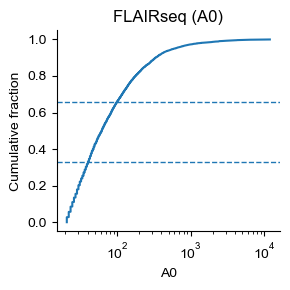

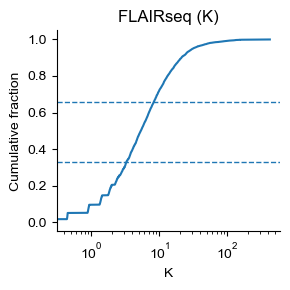

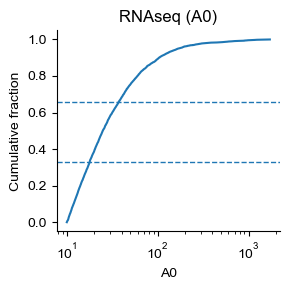

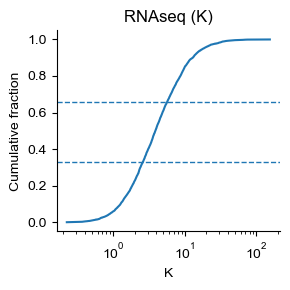

In [19]:
for s in sources:
    print(s)
    d = pd.read_csv("results/selected_genes.%s.csv" % s, index_col=0)
    for c in ["A0", "K"]:
        xs = np.array(list(sorted(d[c])))
        # xs = np.log(xs + 1)
        ys = np.arange(len(xs)) / len(xs)
        plt.figure(figsize=(3, 3))
        plt.title("%s (%s)" % (s, c))
        plt.plot(xs, ys)
        plt.axhline(0.33, lw=1, ls="--")
        plt.axhline(0.66, lw=1, ls="--")
        plt.xlabel(c)
        plt.xscale("log")
        plt.ylabel("Cumulative fraction")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()
        plt.savefig("figures/value_distribution.%s.%s.pdf" % (s, c))

## 3. correlation between A0 and K

FLAIRseq
SignificanceResult(statistic=0.526548491640159, pvalue=0.0)
a=0.71, b=4.35
RNAseq
SignificanceResult(statistic=0.5118404810536995, pvalue=1.8579098730956816e-287)
a=0.72, b=3.28


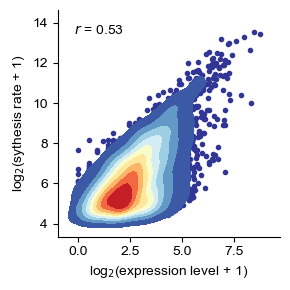

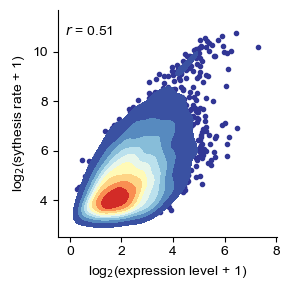

In [3]:
# Scatter for A0 and K

for s in sources:
    print(s)
    dat = pd.read_csv("results/selected_genes.%s.csv" % s, index_col=0)
    dat = dat[np.isfinite(dat["K"])]
    xs = dat["K"]
    ys = dat["A0"]
    r = spearmanr(xs, ys)[0]
    print(spearmanr(xs, ys))
    xs = np.log2(xs + 1)
    ys = np.log2(ys + 1)
    
    a, b = np.polyfit(xs, ys, 1)
    print("a=%.2f, b=%.2f" % (a, b))
    
    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys, marker=".", color=matplotlib.colormaps["RdYlBu_r"](0))
    sns.kdeplot(x=list(xs), y=list(ys), fill=True, cmap='RdYlBu_r', cbar=False, alpha=1, zorder=2)
    xs1 = [min(xs), max(xs)]
    ys1 = [a * x + b for x in xs1]
    # plt.plot(xs1, ys1, color="black", ls="-", lw=1)
    y1, y2 = min(ys), max(ys)
    plt.text(-0.2, y1 + (y2 - y1) * 0.99, "$\it{r}$ = %.2f" % r)
    # plt.text(-0.2, y1 + (y2 - y1) * 0.89, "y = %.2f x + %.2f" % (a, b))
    plt.xlabel("log$_2$(expression level + 1)")
    plt.ylabel("log$_2$(sythesis rate + 1)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/A0_K_scatter.%s.pdf" % s)

## 4. overlap of grouped genes

FLAIRseq
RNAseq


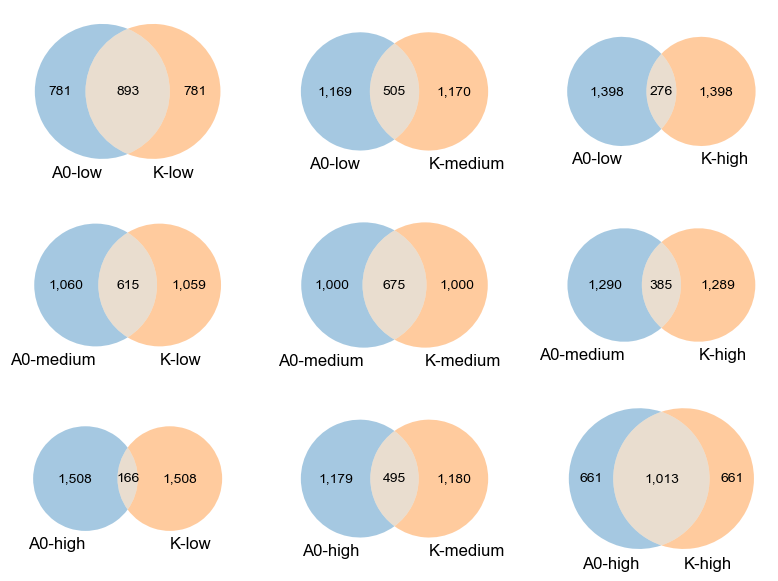

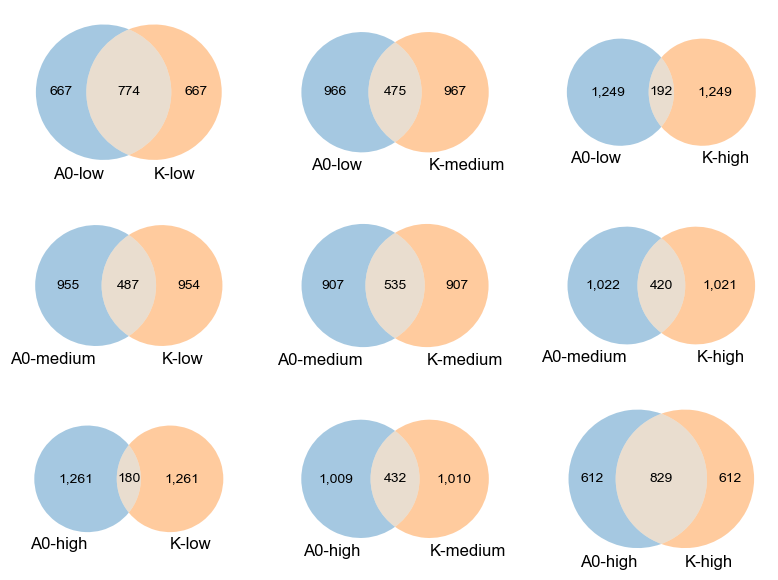

In [21]:
# overlap genes

for s in sources:
    print(s)
    dat = pd.read_csv("results/selected_genes.%s.csv" % s, index_col=0)
    n = int(len(dat) / 3)
    dat = dat.sort_values(by="A0")
    d1 = dat[:n]
    d2 = dat[n:-n]
    d3 = dat[-n:]
    array1 = [d1, d2, d3]
    dat = dat.sort_values(by="K")
    d1 = dat[:n]
    d2 = dat[n:-n]
    d3 = dat[-n:]
    array2 = [d1, d2, d3]

    for i, d in enumerate(array1):
        path = "results/grouped_genes/%s.groupby.A0.%d.csv" % (s, i + 1)
        d.to_csv(path)
        path = "results/grouped_genes/%s.groupby.A0.%d.excluded.csv" % (s, i + 1)
        d = d[~d.index.isin(array2[i].index)]
        d.to_csv(path)
    for i, d in enumerate(array2):
        path = "results/grouped_genes/%s.groupby.K.%d.csv" % (s, i + 1)
        d.to_csv(path)
        path = "results/grouped_genes/%s.groupby.K.%d.excluded.csv" % (s, i + 1)
        d = d[~d.index.isin(array1[i].index)]
        d.to_csv(path)
    
    array = [array1, array2]
    labels = ["low", "medium", "high"]
    fig, axs = plt.subplots(3, 3, figsize=(8, 6))
    for i in range(3):
        for j in range(3):
            ax = axs[i][j]
            plt.sca(ax)
            d1 = array[0][i]
            d2 = array[1][j]
            ret = venn2([set(d1.index), set(d2.index)], set_labels=["A0-%s" % labels[i], "K-%s" % labels[j]], set_colors=["C0", "C1"])
            for item in ret.subset_labels:
                item.set_text(format(int(item.get_text()), ","))
    plt.tight_layout()
    plt.savefig("figures/overlap_split_genes.%s.pdf" % s)

## 5. comparison of signal

In [22]:
config = {
    "H3K27ac_fc": {
        "bw": "data/encode_k562_chipseq/H3K27ac/ENCFF381NDD_H3K27ac_fc.bigWig",
        "bed": "data/encode_k562_chipseq/H3K27ac/ENCFF544LXB_H3K27ac_peaks.bed.gz"
    },
    "H3K27ac_signal_pval": {
        "bw": "data/encode_k562_chipseq/H3K27ac/ENCFF465GBD_H3K27ac_signal_pval.bigWig",
        "bed": "data/encode_k562_chipseq/H3K27ac/ENCFF544LXB_H3K27ac_peaks.bed.gz"
    },
    
    "H3K27me3_fc": {
        "bw": "data/encode_k562_chipseq/H3K27me3/ENCFF242ENK_H3K27me3_fc.bigWig",
        "bed": "data/encode_k562_chipseq/H3K27me3/ENCFF323WOT_H3K27me3_peaks.bed.gz"
    },
    "H3K27me3_signal_pval": {
        "bw": "data/encode_k562_chipseq/H3K27me3/ENCFF582IMB_H3K27me3_signal_pval.bigWig",
        "bed": "data/encode_k562_chipseq/H3K27me3/ENCFF323WOT_H3K27me3_peaks.bed.gz"
    },
    
    "H3K4me1_fc": {
        "bw": "data/encode_k562_chipseq/H3K4me1/ENCFF607SUJ_H3K4me1_fc.bigWig",
        "bed": "data/encode_k562_chipseq/H3K4me1/ENCFF135ZLM_H3K4me1_peaks.bed.gz"
    },
    "H3K4me1_signal_pval": {
        "bw": "data/encode_k562_chipseq/H3K4me1/ENCFF457URZ_H3K4me1_signal_pval.bigWig",
        "bed": "data/encode_k562_chipseq/H3K4me1/ENCFF135ZLM_H3K4me1_peaks.bed.gz"
    },
    
    "H3K4me3_fc": {
        "bw": "data/encode_k562_chipseq/H3K4me3/ENCFF660WUG_H3K4me3_fc.bigWig",
        "bed": "data/encode_k562_chipseq/H3K4me3/ENCFF689QIJ_H3K4me3_peaks.bed.gz"
    },
    "H3K4me3_signal_pval": {
        "bw": "data/encode_k562_chipseq/H3K4me3/ENCFF767UON_H3K4me3_signal_pval.bigWig",
        "bed": "data/encode_k562_chipseq/H3K4me3/ENCFF689QIJ_H3K4me3_peaks.bed.gz"
    },

    "H3K9ac_fc": {
        "bw": "data/encode_k562_chipseq/H3K9ac/ENCFF286WRJ_H3K9ac_fc.bigWig",
        "bed": "data/encode_k562_chipseq/H3K9ac/ENCFF891CHI_H3K9ac_peaks.bed.gz"
    },
    "H3K9ac_signal_pval": {
        "bw": "data/encode_k562_chipseq/H3K9ac/ENCFF239EBH_H3K9ac_signal_pval.bigWig",
        "bed": "data/encode_k562_chipseq/H3K9ac/ENCFF891CHI_H3K9ac_peaks.bed.gz"
    },

    "H3K9me3_fc": {
        "bw": "data/encode_k562_chipseq/H3K9me3/ENCFF601JGK_H3K9me3_fc.bigWig",
        "bed": "data/encode_k562_chipseq/H3K9me3/ENCFF963GZJ_H3K9me3_peaks.bed.gz"
    },
    "H3K9me3_signal_pval": {
        "bw": "data/encode_k562_chipseq/H3K9me3/ENCFF632NQA_H3K9me3_signal_pval.bigWig",
        "bed": "data/encode_k562_chipseq/H3K9me3/ENCFF963GZJ_H3K9me3_peaks.bed.gz"
    },
    # "5mC": {
    #     "bw": "/home/chenzonggui/liujune/0_Analysis/data/encode_k562_m5c/methy_stat_plus_ENCFF459XNY.bigWig",
    #     "bed": None
    # },
    # "ATAC_signal_pval": {
    #     "bw": "data/encode_k562_atacseq/ENCFF357GNC_signal_p_value.bigWig",
    #     "bed": "data/encode_k562_atacseq/ENCFF333TAT_pseudoreplicated_peaks.bed.gz"
    # },
}

In [23]:
def get_tss_regions(dat, width=5000):
    regions = []
    for gid, (chrom, start, end, strand) in zip(dat.index, dat[["Chrom", "Start", "End", "Strand"]].values):
        if strand == "+":
            start, end = start - width, start + width
        else:
            start, end = end - width, end + width
        obj = GRange(chrom=chrom, start=start, end=end, name=gid, strand=strand)
        regions.append(obj)
    regions.sort()
    return regions

def load_peaks(f_bed):
    peaks = list(BedFile(f_bed, ncol=4))
    peaks.sort()
    return peaks

def cal_gene_peak_info(dat, f_bed, f_bw):
    regions = get_tss_regions(dat)
    loader = ShiftLoader(load_peaks(f_bed))
    gids = []
    rows = []
    with pyBigWig.open(f_bw) as bw:
        for region in regions:
            peaks1 = list(loader.fetch(obj=region))
            peak_count = 0
            peak_size = 0
            peak_area = 0
            peak_summit = 0
            for peak in peaks1:
                start = max(peak.start, region.start)
                end = min(peak.end, region.end)
                size = end - start
                assert size > 0
                peak_count += 1
                peak_size += size
                vs = np.nan_to_num(bw.values(region.chrom, start, end), 0)
                peak_area += sum(vs)
                peak_summit = max(peak_summit, max(vs))
            gids.append(region.name)
            rows.append([peak_count, peak_size, peak_area, peak_summit])
    df = pd.DataFrame(rows, index=pd.Index(gids, name="GeneID"))
    df.columns = ["PeakCount", "PeakSize", "PeakArea", "PeakSummit"]
    return df

def get_cumulative_xy(vs):
    xs = np.array(list(sorted(vs)))
    ys = np.arange(len(xs)) / len(xs)
    flags = ys < 0.98
    xs, ys = xs[flags], ys[flags]
    return xs, ys

def load_signal_matrix(dat, f_bw, width=5000, wbin=50):
    rows = []
    with pyBigWig.open(f_bw) as bw:
        for chrom, start, end, strand in dat[["Chrom", "Start", "End", "Strand"]].values:
            if strand == "+":
                start1, end1 = start - width, start + width
            else:
                start1, end1 = end - width, end + width
            vs = bw.values(chrom, start1, end1)
            vs = np.nan_to_num(vs, 0)
            if strand == "-":
                vs = vs[::-1]
            vs1 = np.zeros(int(len(vs) / wbin))
            for i, v in enumerate(vs):
                vs1[int(i / wbin)] += v
            vs1 = vs1 / wbin
            rows.append(vs1)
    mtx = pd.DataFrame(rows, index=dat.index, columns=np.arange(-width, width, wbin) + int(wbin / 2))
    return mtx

In [26]:
# prepare data
for source in sources:
    for name in config.keys():
        f_bw, f_bed = config[name]["bw"], config[name]["bed"]
        dat = pd.read_csv("results/selected_genes.%s.csv" % source, index_col=0)
        dat["Start"] = dat["Start"].astype(int)
        dat["End"] = dat["End"].astype(int)
        dat = dat.merge(cal_gene_peak_info(dat, f_bed, f_bw), left_index=True, right_index=True)
        dat.to_csv("results/gene_peak_info/%s.%s.csv" % (source, name))
        
        dat = pd.read_csv("results/selected_genes.%s.csv" % source, index_col=0)
        dat["Start"] = dat["Start"].astype(int)
        dat["End"] = dat["End"].astype(int)
        mtx = load_signal_matrix(dat, f_bw)
        mtx.to_csv("results/signal_matrix/%s.%s.csv" % (source, name))

In [27]:
for name in config.keys():
    print("-" * 80)
    print(name)
    nrow, ncol = 12, 4
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 2.8, nrow * 2.8))
    icol = 0
    for source in ["FLAIRseq", "RNAseq"]:
        print("-" * 40)
        print("Source:", source) 
        dat = pd.read_csv("results/gene_peak_info/%s.%s.csv" % (source, name), index_col=0)
        mtx = pd.read_csv("results/signal_matrix/%s.%s.csv" % (source, name), index_col=0)
        mtx.columns = list(map(int, mtx.columns))
        for c in ["A0", "K"]:
            ds = []
            for i in range(3):
                genes = pd.read_csv("results/grouped_genes/%s.groupby.%s.%d.excluded.csv" % (source, c, i + 1), index_col=0).index
                ds.append(dat.loc[genes])
            
            print([len(d) for d in ds])
                        
            print("Splitted by %s" % c)
            print("Thresholds:")
            for d in ds:
                print("%.2f - %.2f" % (min(d[c]), max(d[c])))
            
            ticks = ["Low", "Medium", "High"]
            ticks = ["G%d" % (i + 1) for i in range(3)]
            for i, column in enumerate(["PeakCount", "PeakSize", "PeakArea", "PeakSummit"]):
                # continue
                
                # boxplot
                ax = axs[i * 2][icol]
                plt.sca(ax)
                plt.title("%s (%s)"  % (s, c))
                xs = np.arange(len(ds))
                plt.boxplot([d[column] for d in ds], positions=xs, showfliers=False, showmeans=True)
                plt.ylabel(column)
                plt.xticks(xs, ticks)
                
                # cumulative fraction
                ax = axs[i * 2 + 1][icol]
                plt.sca(ax)
                plt.title("%s (%s)"  % (s, c))
                for d, tick in zip(ds, ticks):
                    xs, ys = get_cumulative_xy(d[column])
                    plt.plot(xs, ys, label=tick)
                    plt.xlabel(column)
                    plt.ylabel("Cumulative fraction")
                plt.legend()            
                
            ax = axs[8][icol]
            plt.sca(ax)
            for d, tick in zip(ds, ticks):
                mtx1 = mtx.loc[d.index]
                xs = np.array(mtx1.columns)
                ys = np.array(mtx1.sum())
                plt.plot(xs, ys, label=tick)
            plt.xlabel("Positions to TSS")
            plt.ylabel("Signal")
            
            ax = axs[9][icol]
            plt.sca(ax)
            for d, tick in zip(ds, ticks):
                mtx1 = mtx.loc[d.index]
                vs = np.array(mtx1.sum(axis=1))
                xs, ys = get_cumulative_xy(vs)
                plt.plot(xs, ys, label=tick)
            plt.xlabel("Signal")
            plt.ylabel("Cumulative")

            ax = axs[10][icol]
            plt.sca(ax)
            for d, tick in zip(ds, ticks):
                mtx1 = mtx.loc[d.index]
                xs = np.array(mtx1.columns)
                ys = np.array(mtx1.sum())
                for i in range(len(xs)):
                    if -1500 < xs[i] < 1500:
                        ys[i] = 0
                plt.plot(xs, ys, label=tick)
            plt.xlabel("Positions to TSS")
            plt.ylabel("Signal (filtered)")
            ax = axs[11][icol]
            plt.sca(ax)
            for d, tick in zip(ds, ticks):
                mtx1 = mtx.loc[d.index]
                columns = list(filter(lambda item: item < -1500 or item > 1500, mtx1.columns))
                mtx1 = mtx1[columns]
                vs = np.array(mtx1.sum(axis=1))
                xs, ys = get_cumulative_xy(vs)
                plt.plot(xs, ys, label=tick)
            plt.xlabel("Signal (filtered)")
            plt.ylabel("Cumulative")
            icol += 1
    plt.tight_layout()
    if False:
        plt.show()
    else:
        plt.savefig("figures/comparision.%s.pdf" % name)
    plt.close()
    # break

--------------------------------------------------------------------------------
H3K27ac_fc
----------------------------------------
Source: FLAIRseq
[781, 1000, 661]
Splitted by A0
Thresholds:
20.83 - 40.36
41.67 - 102.86
102.86 - 591.14
[781, 1000, 661]
Splitted by K
Thresholds:
0.00 - 3.30
3.44 - 8.49
8.51 - 131.36
----------------------------------------
Source: RNAseq
[667, 907, 612]
Splitted by A0
Thresholds:
10.00 - 17.92
17.92 - 38.15
38.19 - 264.28
[667, 907, 612]
Splitted by K
Thresholds:
0.22 - 2.60
2.61 - 5.77
5.77 - 33.70
--------------------------------------------------------------------------------
H3K27ac_signal_pval
----------------------------------------
Source: FLAIRseq
[781, 1000, 661]
Splitted by A0
Thresholds:
20.83 - 40.36
41.67 - 102.86
102.86 - 591.14
[781, 1000, 661]
Splitted by K
Thresholds:
0.00 - 3.30
3.44 - 8.49
8.51 - 131.36
----------------------------------------
Source: RNAseq
[667, 907, 612]
Splitted by A0
Thresholds:
10.00 - 17.92
17.92 - 38.15
38.

FLAIRseq	H3K4me3_signal_pval	A0
FLAIRseq	H3K4me3_signal_pval	K
RNAseq	H3K4me3_signal_pval	A0
RNAseq	H3K4me3_signal_pval	K
FLAIRseq	H3K27ac_signal_pval	A0
FLAIRseq	H3K27ac_signal_pval	K
RNAseq	H3K27ac_signal_pval	A0
RNAseq	H3K27ac_signal_pval	K
FLAIRseq	H3K9ac_signal_pval	A0
FLAIRseq	H3K9ac_signal_pval	K
RNAseq	H3K9ac_signal_pval	A0
RNAseq	H3K9ac_signal_pval	K


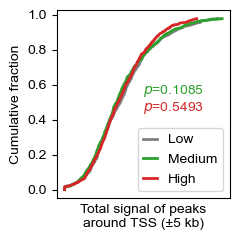

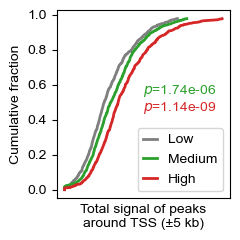

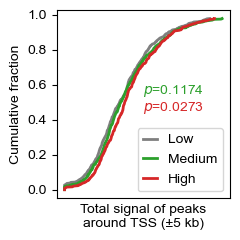

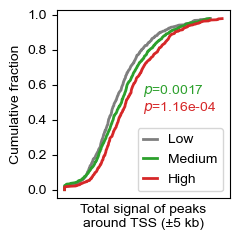

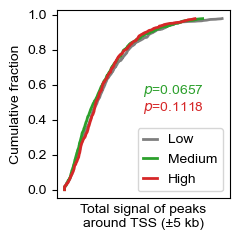

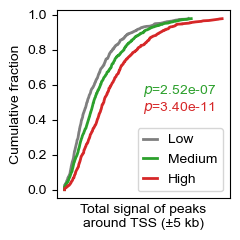

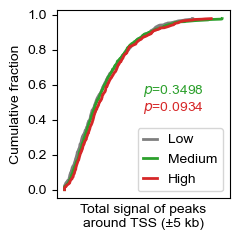

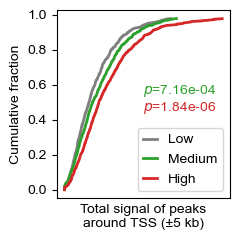

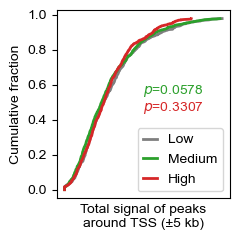

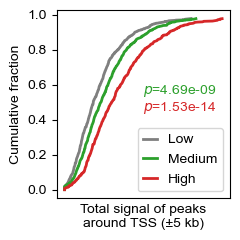

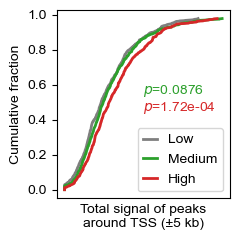

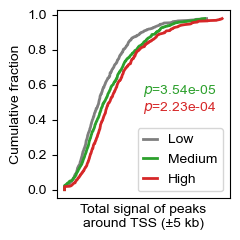

In [28]:
names = ["H3K4me3_signal_pval", "H3K27ac_signal_pval", "H3K9ac_signal_pval"]
variables = ["A0", "K"]
colors = ["C7", "C2", "C3"]
labels = ["Low", "Medium", "High"]
column = "PeakArea"
for name in names:
    for source in sources:
        for variable in variables:
            print(source, name, variable, sep="\t")
            path = "results/gene_peak_info/%s.%s.csv" % (source, name)
            dat = pd.read_csv(path, index_col=0)
            plt.figure(figsize=(2.5, 2.5))
            array = []
            for i in range(3):
                genes = pd.read_csv("results/grouped_genes/%s.groupby.%s.%d.excluded.csv" % (source, variable, i + 1), index_col=0).index.values
                d = dat.loc[genes]
                xs, ys = get_cumulative_xy(d[column])
                array.append([xs, ys])
                plt.plot(xs, ys, lw=2, color=colors[i], label=labels[i])
                
            xlim1, xlim2 = plt.gca().get_xlim()
            for i in range(3):
                if i > 0:
                    xs1 = array[i-1][0]
                    xs2 = array[i][0]
                    ret = mannwhitneyu(xs1, xs2)
                    # print(ret)
                    pval = ret[1]
                    x = xlim1 + (xlim2 - xlim1) * 0.5
                    text = "$\it{p}$=%.2e" % pval
                    if pval > 0.001:
                        text = "$\it{p}$=%.4f" % pval
                    plt.text(x, 0.65 - 0.1 * i, text, color=colors[i])
            # plt.xlim(-50, 650)
            plt.xticks([])
            # plt.yticks([])
            plt.xlabel("Total signal of peaks\naround TSS (±5 kb)")
            plt.ylabel("Cumulative fraction")
            plt.legend(handlelength=1)
            plt.tight_layout()
            plt.savefig("figures/cumulative_fraction.%s.%s.%s.%s.pdf" % (source, name, variable, column))

## 6. Signal of peak area

FLAIRseq	H3K4me3_signal_pval	A0
SignificanceResult(statistic=0.22648459358259485, pvalue=2.1228454938460142e-58)
a=0.15, b=15.41


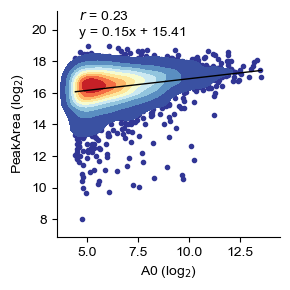

FLAIRseq	H3K4me3_signal_pval	K
SignificanceResult(statistic=0.32174232161099, pvalue=3.648059821759417e-119)
a=0.23, b=15.70


<Figure size 640x480 with 0 Axes>

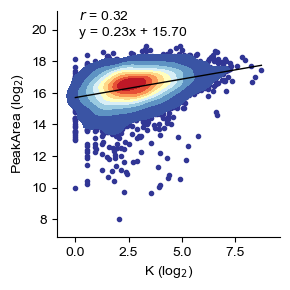

RNAseq	H3K4me3_signal_pval	A0
SignificanceResult(statistic=0.27468112396976263, pvalue=1.8497793329714472e-74)
a=0.20, b=15.47


<Figure size 640x480 with 0 Axes>

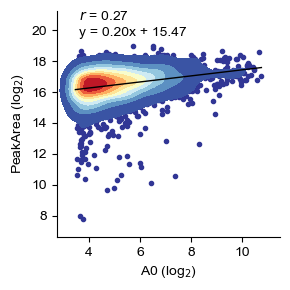

RNAseq	H3K4me3_signal_pval	K
SignificanceResult(statistic=0.3267184677978111, pvalue=2.6311576377022545e-106)
a=0.28, b=15.77


<Figure size 640x480 with 0 Axes>

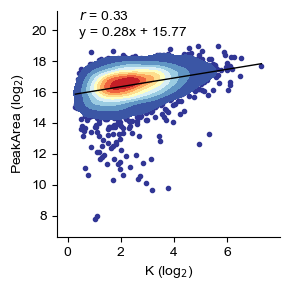

FLAIRseq	H3K27ac_signal_pval	A0
SignificanceResult(statistic=0.20948027282205417, pvalue=8.669714434728502e-50)
a=0.21, b=15.43


<Figure size 640x480 with 0 Axes>

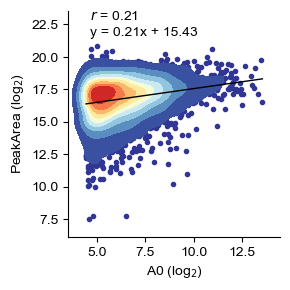

FLAIRseq	H3K27ac_signal_pval	K
SignificanceResult(statistic=0.3034995929088721, pvalue=4.443502610161925e-105)
a=0.34, b=15.85


<Figure size 640x480 with 0 Axes>

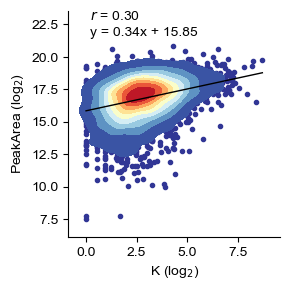

RNAseq	H3K27ac_signal_pval	A0
SignificanceResult(statistic=0.24886409154575062, pvalue=5.89448784432691e-61)
a=0.28, b=15.44


<Figure size 640x480 with 0 Axes>

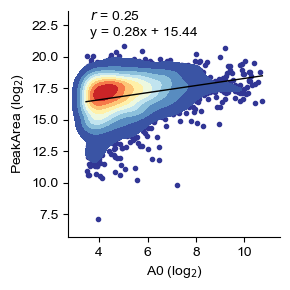

RNAseq	H3K27ac_signal_pval	K
SignificanceResult(statistic=0.3181856392315459, pvalue=1.6379304073066866e-100)
a=0.44, b=15.80


<Figure size 640x480 with 0 Axes>

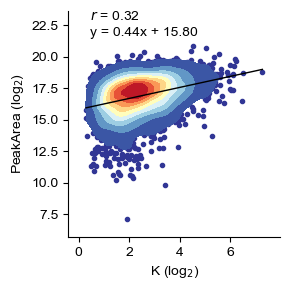

FLAIRseq	H3K9ac_signal_pval	A0
SignificanceResult(statistic=0.25860986746828185, pvalue=6.456314156540028e-76)
a=0.22, b=15.41


<Figure size 640x480 with 0 Axes>

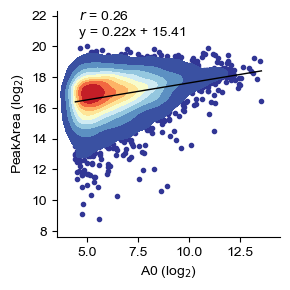

FLAIRseq	H3K9ac_signal_pval	K
SignificanceResult(statistic=0.3729599972342161, pvalue=5.35763293023412e-162)
a=0.35, b=15.85


<Figure size 640x480 with 0 Axes>

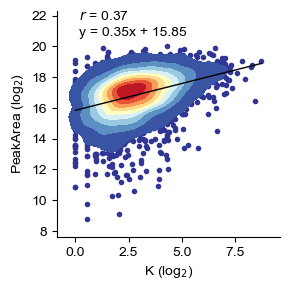

RNAseq	H3K9ac_signal_pval	A0
SignificanceResult(statistic=0.3180945294665145, pvalue=2.731301457293273e-100)
a=0.30, b=15.45


<Figure size 640x480 with 0 Axes>

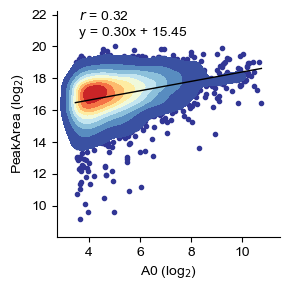

RNAseq	H3K9ac_signal_pval	K
SignificanceResult(statistic=0.3622157288771009, pvalue=1.34932408142118e-131)
a=0.41, b=15.95


<Figure size 640x480 with 0 Axes>

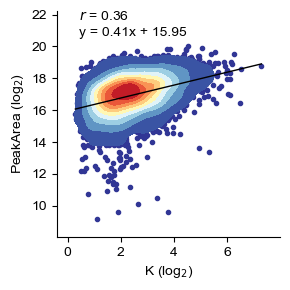

FLAIRseq	H3K4me1_signal_pval	A0
SignificanceResult(statistic=0.06898555899155591, pvalue=2.6483890017195686e-06)
a=0.07, b=12.70


<Figure size 640x480 with 0 Axes>

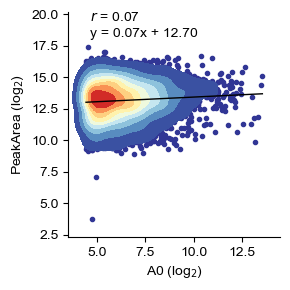

FLAIRseq	H3K4me1_signal_pval	K
SignificanceResult(statistic=0.07127625320598907, pvalue=1.2179447351872927e-06)
a=0.10, b=12.90


<Figure size 640x480 with 0 Axes>

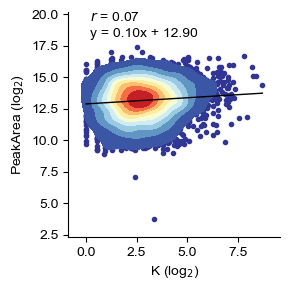

RNAseq	H3K4me1_signal_pval	A0
SignificanceResult(statistic=0.09504671458626819, pvalue=1.5165237631303753e-09)
a=0.11, b=12.61


<Figure size 640x480 with 0 Axes>

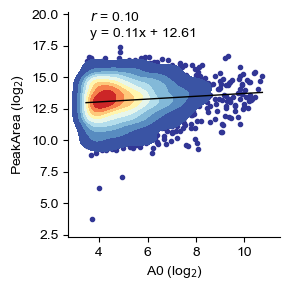

RNAseq	H3K4me1_signal_pval	K
SignificanceResult(statistic=0.12533092821803923, pvalue=1.4472704698211397e-15)
a=0.19, b=12.72


<Figure size 640x480 with 0 Axes>

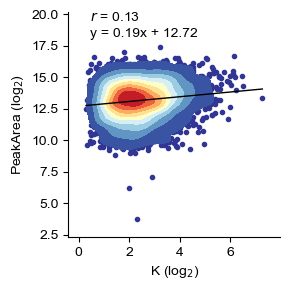

FLAIRseq	H3K27me3_signal_pval	A0
SignificanceResult(statistic=0.033412858803089175, pvalue=0.6868371357127969)
a=0.06, b=11.02


<Figure size 640x480 with 0 Axes>

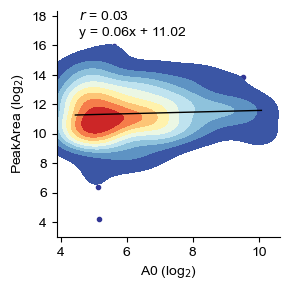

FLAIRseq	H3K27me3_signal_pval	K
SignificanceResult(statistic=0.1431301578111497, pvalue=0.08266353599147548)
a=0.14, b=11.03


<Figure size 640x480 with 0 Axes>

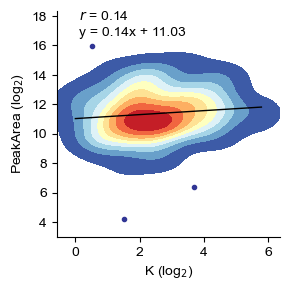

RNAseq	H3K27me3_signal_pval	A0
SignificanceResult(statistic=0.0018778998755466251, pvalue=0.9820525183515554)
a=0.03, b=11.38


<Figure size 640x480 with 0 Axes>

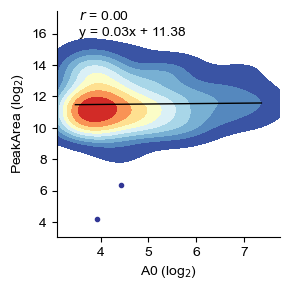

RNAseq	H3K27me3_signal_pval	K
SignificanceResult(statistic=0.17518068038210102, pvalue=0.03443807749307487)
a=0.27, b=10.94


<Figure size 640x480 with 0 Axes>

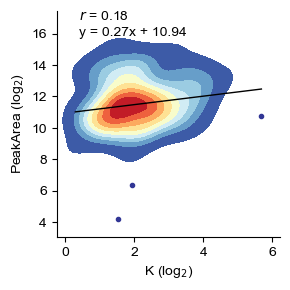

FLAIRseq	H3K9me3_signal_pval	A0
SignificanceResult(statistic=-0.05118849412239576, pvalue=0.2790966431216086)
a=-0.07, b=11.41


<Figure size 640x480 with 0 Axes>

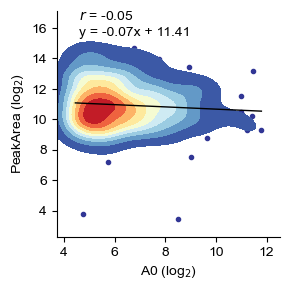

FLAIRseq	H3K9me3_signal_pval	K
SignificanceResult(statistic=-0.054788256583317964, pvalue=0.24662883721221082)
a=-0.05, b=11.07


<Figure size 640x480 with 0 Axes>

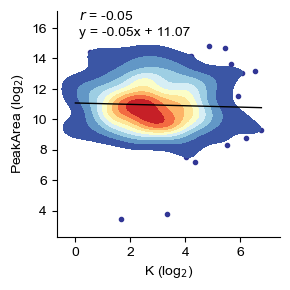

RNAseq	H3K9me3_signal_pval	A0
SignificanceResult(statistic=-0.08050816619222027, pvalue=0.11289056866485941)
a=-0.09, b=11.40


<Figure size 640x480 with 0 Axes>

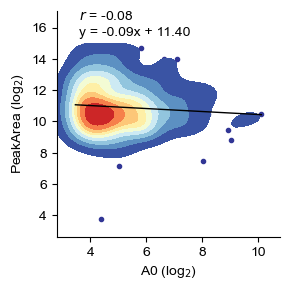

RNAseq	H3K9me3_signal_pval	K
SignificanceResult(statistic=-0.07020682794173608, pvalue=0.1669886865513343)
a=-0.15, b=11.29


<Figure size 640x480 with 0 Axes>

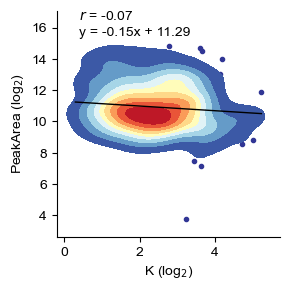

<Figure size 640x480 with 0 Axes>

In [4]:
names = ["H3K4me3_signal_pval", "H3K27ac_signal_pval", "H3K9ac_signal_pval", 
         "H3K4me1_signal_pval", "H3K27me3_signal_pval", "H3K9me3_signal_pval"]
variables = ["A0", "K"]
column = "PeakArea"
for name in names:
    for source in sources:
        for variable in variables:
            print(source, name, variable, sep="\t")
            path = "results/gene_peak_info/%s.%s.csv" % (source, name)
            dat = pd.read_csv(path, index_col=0)
            tmp = dat[dat[column] > 0]
            xs = tmp[variable]
            ys = tmp[column]
            xs = np.log2(xs + 1)
            ys = np.log2(ys + 1)
            r = spearmanr(xs, ys)[0]
            print(spearmanr(xs, ys))
            a, b = np.polyfit(xs, ys, 1)
            print("a=%.2f, b=%.2f" % (a, b))

            plt.figure(figsize=(3, 3))
            plt.scatter(xs, ys, marker=".", color=matplotlib.colormaps["RdYlBu_r"](0))
            sns.kdeplot(x=list(xs), y=list(ys), fill=True, cmap='RdYlBu_r', cbar=False, alpha=1, zorder=2)
            xs1 = [min(xs), max(xs)]
            ys1 = [a * x + b for x in xs1]
            # plt.plot(xs1, ys1, color="black", ls="-", lw=1)
            x1, x2 = min(xs), max(xs)
            w = x2 - x1
            x1 -= w * 0.1
            x2 += w * 0.1
            y1, y2 = min(ys), max(ys)
            h = y2 - y1
            y1 -= h * 0.1
            y2 += h * 0.2
            plt.xlim(x1, x2)
            plt.ylim(y1, y2)
            plt.text(x1 + (x2 - x1) * 0.1, y1 + (y2 - y1) * 0.96, "$\it{r}$ = %.2f" % r)
            plt.text(x1 + (x2 - x1) * 0.1, y1 + (y2 - y1) * 0.89, "y = %.2fx + %.2f" % (a, b))
            plt.xlabel("%s (log$_2$)" % variable)
            plt.ylabel("%s (log$_2$)" % column)
            plt.gca().spines["top"].set_visible(False)
            plt.gca().spines["right"].set_visible(False)
            plt.tight_layout()
            plt.show()
            plt.close()
            plt.savefig("figures/A0_K_scatter.%s.pdf" % s, dpi=300)    

## 7. Total signal (signal p-value)

In [5]:
names = ["H3K4me3_signal_pval", "H3K27ac_signal_pval", "H3K9ac_signal_pval", 
         "H3K4me1_signal_pval", "H3K27me3_signal_pval", "H3K9me3_signal_pval"]
variables = ["A0", "K"]
column = "TotalSignal"
cmap = plt.colormaps["RdYlBu_r"]
rs = dict()
for name in names:
    for source in sources:
        for variable in variables:
            print(source, name, variable, sep="\t")
            path = "results/gene_peak_info/%s.%s.csv" % (source, name)
            path2 = "results/signal_matrix/%s.%s.csv" % (source, name)
            dat = pd.read_csv(path, index_col=0)
            dat2 = pd.read_csv(path2, index_col=0)
            dat[column] = dat2.sum(axis=1)
            tmp = dat[dat[column] > 0]
            xs = tmp[variable] / 100
            ys = tmp[column]
            xs = np.log2(xs + 1)
            ys = np.log2(ys + 1)
            r = spearmanr(xs, ys)[0]
            rs[(source, name, variable)] = r
            print(spearmanr(xs, ys))
            a, b = np.polyfit(xs, ys, 1)
            print("a=%.2f, b=%.2f" % (a, b))

            plt.figure(figsize=(2.5, 2.5))
            plt.scatter(xs, ys, marker=".", color=cmap(0))
            sns.kdeplot(x=list(xs), y=list(ys), fill=True, cmap=cmap, cbar=False, alpha=1, zorder=2)
            xs1 = [min(xs), max(xs)]
            ys1 = [a * x + b for x in xs1]
            #plt.plot(xs1, ys1, color="black", ls="-", lw=1)
            x1, x2 = min(xs), max(xs)
            w = x2 - x1
            x1 -= w * 0.1
            x2 += w * 0.1
            y1, y2 = min(ys), max(ys)
            h = y2 - y1
            y1 -= h * 0.1
            y2 += h * 0.2
            plt.xlim(x1, x2)
            plt.ylim(y1, y2)
            plt.text(x1 + (x2 - x1) * 0.1, y1 + (y2 - y1) * 0.96, "$\it{r}$ = %.2f" % r)
            #plt.text(x1 + (x2 - x1) * 0.1, y1 + (y2 - y1) * 0.89, "y=%.2f x + %.2f" % (a, b))
            if variable == "A0":
                plt.xlabel("Expression level (log$_2$)")
            else:
                plt.xlabel("Synthesis rate (log$_2$)")
            plt.ylabel("Signal of %s (log$_2$)" % name.split("_")[0])
            plt.gca().spines["top"].set_visible(False)
            plt.gca().spines["right"].set_visible(False)
            plt.tight_layout()
            plt.savefig("figures/scatter.%s_vs_%s.%s.pdf" % (name, variable, source))
            plt.close()

FLAIRseq	H3K4me3_signal_pval	A0
SignificanceResult(statistic=0.22678546871489758, pvalue=1.333903644516275e-59)
a=0.25, b=10.46
FLAIRseq	H3K4me3_signal_pval	K
SignificanceResult(statistic=0.3221399107549092, pvalue=1.22128796680092e-121)
a=1.48, b=10.52
RNAseq	H3K4me3_signal_pval	A0
SignificanceResult(statistic=0.2798853232604401, pvalue=1.1955548423313486e-78)
a=0.47, b=10.58
RNAseq	H3K4me3_signal_pval	K
SignificanceResult(statistic=0.32642698318989294, pvalue=6.7213941986417066e-108)
a=2.91, b=10.57
FLAIRseq	H3K27ac_signal_pval	A0
SignificanceResult(statistic=0.21269438970472032, pvalue=1.768651770499687e-52)
a=0.36, b=10.70
FLAIRseq	H3K27ac_signal_pval	K
SignificanceResult(statistic=0.311990032758357, pvalue=7.993994416501728e-114)
a=2.27, b=10.78
RNAseq	H3K27ac_signal_pval	A0
SignificanceResult(statistic=0.25406833101464993, pvalue=1.1283173025593736e-64)
a=0.65, b=10.85
RNAseq	H3K27ac_signal_pval	K
SignificanceResult(statistic=0.3207184836343996, pvalue=5.100960884497607e-104)
a=4

In [31]:
rows = []
for name in names:
    row = []
    for source in sources:
        row.append(rs[(source, name, "A0")])
        row.append(rs[(source, name, "K")])
    rows.append(row)
m = pd.DataFrame(rows, index=[name.split("_")[0] for name in names], 
                 columns=["FLAIR-seq.A0", "FLAIR-seq.K", "RNA-seq.A0", "RNA-seq.K"])
m = m[["RNA-seq.A0", "RNA-seq.K", "FLAIR-seq.A0", "FLAIR-seq.K"]]
m.columns = ["Expression\nlevel", "Synthesis\nrate", "Expression\nlevel", "Synthesis\nrate"]
m

,Expression\nlevel,Synthesis\nrate,Expression\nlevel,Synthesis\nrate
H3K4me3,0.279885,0.326427,0.226785,0.322140
H3K27ac,0.254068,0.320718,0.212694,0.311990
H3K9ac,0.319968,0.360970,0.257978,0.372050
H3K4me1,0.103109,0.148877,0.083807,0.093813
H3K27me3,-0.047567,-0.057061,-0.013962,-0.020127
H3K9me3,0.053695,0.025791,0.075469,0.069594


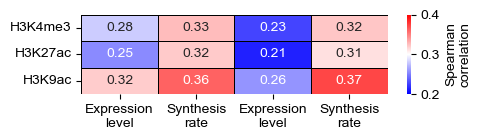

In [32]:
plt.figure(figsize=(5, 1.5))
ax = sns.heatmap(m.head(3), cmap="bwr", vmin=0.2, vmax=0.4, annot=True, fmt=".2f", lw=0.5, linecolor="black", cbar_kws=dict(label="Spearman\ncorrelation"))
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.savefig("figures/heatmap_spearman_correlation.pdf")

## 8. Sum of signal

In [33]:
names = ["H3K4me3_signal_pval", "H3K27ac_signal_pval", "H3K9ac_signal_pval", 
         "H3K4me1_signal_pval", "H3K27me3_signal_pval", "H3K9me3_signal_pval"]
variables = ["A0", "K"]
column = "SumSignal"
for source in sources:
    for variable in variables:
        print(source, variable, sep="\t")
        path = "results/selected_genes.%s.csv" % source
        dat = pd.read_csv(path, index_col=0)

        ss = [pd.read_csv("results/signal_matrix/%s.%s.csv" % (source, name), index_col=0).sum(axis=1) for name in names]
        s1, s2, s3, s4, s5, s6 = ss
        
        dat[column] = s1 + s2 + s3 - s5 - s6
        tmp = dat[dat[column] > 0]
        xs = tmp[variable]
        ys = tmp[column]
        xs = np.log2(xs + 1)
        ys = np.log2(ys + 1)
        r = spearmanr(xs, ys)[0]
        print(spearmanr(xs, ys))
        a, b = np.polyfit(xs, ys, 1)
        print("a=%.2f, b=%.2f" % (a, b))

        if False:
            plt.figure(figsize=(3, 3))
            plt.scatter(xs, ys, marker=".", color=matplotlib.colormaps["RdYlBu_r"](0))
            sns.kdeplot(x=list(xs), y=list(ys), fill=True, cmap='RdYlBu_r', cbar=False, alpha=1, zorder=2)
            xs1 = [min(xs), max(xs)]
            ys1 = [a * x + b for x in xs1]
            plt.plot(xs1, ys1, color="black", ls="-", lw=1)
            x1, x2 = min(xs), max(xs)
            w = x2 - x1
            x1 -= w * 0.1
            x2 += w * 0.1
            y1, y2 = min(ys), max(ys)
            h = y2 - y1
            y1 -= h * 0.1
            y2 += h * 0.2
            plt.xlim(x1, x2)
            plt.ylim(y1, y2)
            plt.text(x1 + (x2 - x1) * 0.1, y1 + (y2 - y1) * 0.96, "r = %.2f" % r)
            plt.text(x1 + (x2 - x1) * 0.1, y1 + (y2 - y1) * 0.89, "y = %.2f x + %.2f" % (a, b))
            plt.xlabel("%s (log$_2$)" % variable)
            plt.ylabel("%s (log$_2$)" % column)
            plt.gca().spines["top"].set_visible(False)
            plt.gca().spines["right"].set_visible(False)
            plt.tight_layout()
            plt.show()
            plt.close()
            # plt.savefig("figures/A0_K_scatter.%s.pdf" % s, dpi=300)    

FLAIRseq	A0
SignificanceResult(statistic=0.24468107817377777, pvalue=5.683954781765413e-69)
a=0.21, b=11.32
FLAIRseq	K
SignificanceResult(statistic=0.3526129367722586, pvalue=4.057704991632398e-146)
a=0.32, b=11.73
RNAseq	A0
SignificanceResult(statistic=0.2971124846087779, pvalue=2.1767065400733816e-88)
a=0.27, b=11.35
RNAseq	K
SignificanceResult(statistic=0.35543603302972976, pvalue=2.850753858488462e-128)
a=0.39, b=11.78
